Aqui serão estudadas as relações entre as variavéis, de modo a fornecer uma regressão para a aplicação do streamlit e maiores explicações sobre como a regressão mostrada lá foi feita.

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from scipy.stats import ks_2samp
import statsmodels.formula.api as smf
from sklearn.metrics import roc_curve

In [57]:
bank = pd.read_csv('./Material_de_apoio_M19_Cientista de Dados/data/input/bank-additional-full.csv', sep= ';')
bank

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [58]:
# Aqui iremos renomear as colunas de modo a tirar o '.' dos nomes
bank = bank.rename(columns={'emp.var.rate':'emp_var_rate',
                'cons.price.idx': 'cons_price_idx',
                'cons.conf.idx': 'cons_conf_idx',
                'nr.employed':'nr_employed'})

In [59]:
bank.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')

In [60]:
bank.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp_var_rate      float64
cons_price_idx    float64
cons_conf_idx     float64
euribor3m         float64
nr_employed       float64
y                  object
dtype: object

In [62]:
# Transformando os valores categóricos de 'y' em numéricos
bank['y'] = bank['y'].replace({'yes': 1, 'no': 0})
# Lista de variáveis categóricas
variaveis_categoricas = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
# Criação de variáveis dummy
dummies = pd.get_dummies(bank[variaveis_categoricas])
# Concatenar as variáveis dummy ao DataFrame original
bank = pd.concat([bank, dummies], axis=1)
# Remover as variáveis originais
bank.drop(variaveis_categoricas, axis=1, inplace=True)

In [63]:
bank.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'mon

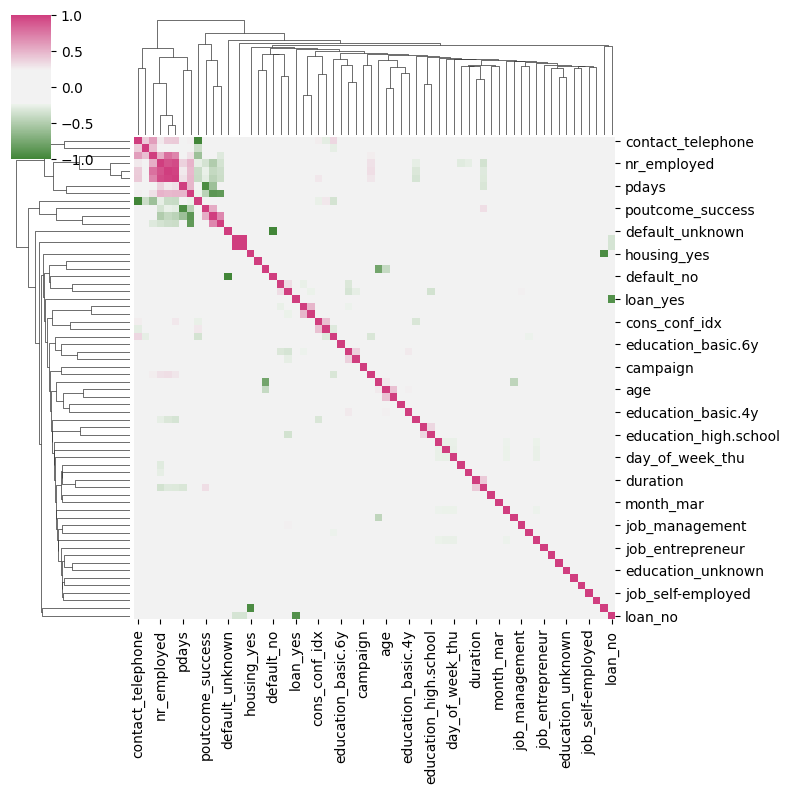

In [64]:
cmap = sns.diverging_palette(h_neg=125, h_pos=350, as_cmap=True, sep = 60, center = 'light')
sns.clustermap(bank.corr(), figsize= (8,8), center = 0, cmap = cmap)

In [65]:
bank.corr()['y']

age                     0.030399
duration                0.405274
campaign               -0.066357
pdays                  -0.324914
previous                0.230181
                          ...   
day_of_week_tue         0.008046
day_of_week_wed         0.006302
poutcome_failure        0.031799
poutcome_nonexistent   -0.193507
poutcome_success        0.316269
Name: y, Length: 64, dtype: float64

In [66]:
# Calcular as correlações (valores absolutos)
bank.corr()['y'].abs().sort_values(ascending= False).head(10)

y                       1.000000
duration                0.405274
nr_employed             0.354678
pdays                   0.324914
poutcome_success        0.316269
euribor3m               0.307771
emp_var_rate            0.298334
previous                0.230181
poutcome_nonexistent    0.193507
contact_telephone       0.144773
Name: y, dtype: float64

In [67]:
# Criando a regressão, aqui, foram deixadas inicialmente todas as 10 variáveis com a maior correlação com 'y'.
# Após isso, foram reitradas as variáveis com p-values maiores que 5%, de modo a simplificar o modelo.
reg_pura = smf.logit("y ~  duration + pdays  + poutcome_success + emp_var_rate + euribor3m + nr_employed + poutcome_nonexistent + contact_telephone"
                     ,data= bank).fit()
reg_pura.summary()

Optimization terminated successfully.
         Current function value: 0.218175
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                41188
Model:                          Logit   Df Residuals:                    41179
Method:                           MLE   Df Model:                            8
Date:                Sun, 25 Feb 2024   Pseudo R-squ.:                  0.3802
Time:                        18:21:35   Log-Likelihood:                -8986.2
converged:                       True   LL-Null:                       -14499.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       87.5701      3.485     25.126      0.000      80.739      94.401
poutcome_success[T.True]         0.9687      0.199      4.865      0.000       0.578       1.359
poutcome_nonexistent[T.True]     0.5702      0.062      9.261      0.000       0.450       0.691
contact_telephone[T.True]       -0.6961      0.057    -12.151      0.000      -0.808      -0.584
duration                         0.0045   7.17e-05     63.138      0.000       0.004       0.005
pdays                           -0.0010      0.000     -5.265      0.000      -0.001      -0.001
emp_var_rate                    -0.5370      0.040    -13.469      0.000      -0.615      -0.459
euribor3m                        0.6431      0.055     11.783      0.000       0.536       0.750
nr_employed                     -0.0181      0.001    -25.553      0.000      -0.019      -0.017
================================================================================================
"""

In [70]:
# Aqui iremos criar uma coluna sobre os valores preditos e categorizar a base de dados em 5 grupos, com base na coluna 'preditos'.
bank['predito'] = reg_pura.predict()
cat_pred = pd.qcut(bank['predito'], 5, duplicates= 'drop')
cat_pred.value_counts().sort_index()

predito
(0.0027, 0.0119]    8238
(0.0119, 0.0204]    8239
(0.0204, 0.0465]    8236
(0.0465, 0.143]     8238
(0.143, 1.0]        8237
Name: count, dtype: int64

In [73]:
group_reg = bank.groupby(cat_pred)
qualid = group_reg[['predito']].count().rename(columns = {'predito': 'contagem'})
qualid['predito'] = group_reg['predito'].mean()
qualid['pct_y'] = group_reg['y'].mean()
qualid

C:\Users\samsun\AppData\Local\Temp\ipykernel_2532\74001630.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_reg = bank.groupby(cat_pred)


,contagem,predito,pct_y
predito,,,
"(0.0027, 0.0119]",8238,0.008506,0.000486
"(0.0119, 0.0204]",8239,0.015427,0.002306
"(0.0204, 0.0465]",8236,0.030801,0.013963
"(0.0465, 0.143]",8238,0.082127,0.093348
"(0.143, 1.0]",8237,0.426439,0.453199


Text(0.5, 1.0, 'Curva de calibragem')

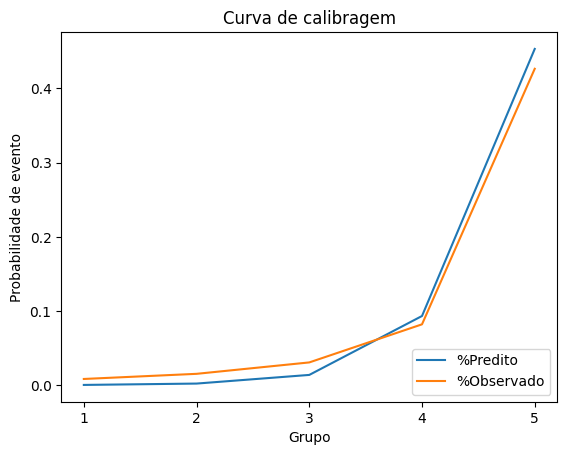

In [78]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = qualid['pct_y'].plot(label='%Predito')
ax = qualid['predito'].plot(label='%Observado')

ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')
plt.title('Curva de calibragem')

In [75]:
#Calculando a acurácia
acc = metrics.accuracy_score(bank['y'], bank['predito']>.5)
#Calculando o GINI
fpr, tpr, thresholds = metrics.roc_curve(bank['y'], bank['predito'])
auc_ = metrics.auc(fpr, tpr)
gini = 2*auc_ -1
#Calculando o KS
ks = ks_2samp(bank.loc[bank['y'] == 1, 'predito'], bank.loc[bank['y'] != 1, 'predito']).statistic

print(f'Acurácia: {(acc*100):.2f}%\nGINI: {(gini*100):.2f}%\nKS: {(ks*100):.2f}%')

Acurácia: 90.97%
GINI: 85.08%
KS: 70.91%
